Name : Akshaya Brian Tauro, Course Number : CS 584, Semester : Fall 2022

####This file consists of code which has Meta learning model(Reptile Algorithm - Few shot learning) for the respiratory disease detection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import matplotlib.pyplot as plt
from numpy import asarray
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:

img_rows = 150
img_cols = 150


learning_rate = 0.001
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25
#How many different tasks we are going to sample
iterations = 1000
eval_iters = 5
#steps to be done in each sampled task
inner_iters = 4 

eval_interval = 1
train_shots = 20
#shots is k, which is the number of examples 
shots = 5 
classes = 4

In [ ]:

from keras.preprocessing.image import ImageDataGenerator
import urllib3
import numpy       
urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.

#Define the data loader       
class Dataset:
  
    train_dataset_path = r"/content/drive/MyDrive/Colab Notebooks/ML/ML_Project/data/splidata/train"
    test_dataset_path = r"/content/drive/MyDrive/Colab Notebooks/ML/ML_Project/data/splidata/test"

    #pre-process the data for actual logic, for the inner loop optimization task
    def __init__(self, training):
   
        if training:
            datagen  = ImageDataGenerator(rescale=1./255)
            path = self.train_dataset_path
        else:
            datagen = ImageDataGenerator(rescale=1./255)
            path =  self.test_dataset_path
        
        #to shrink the image to the desired size, scale the pixel values and convert the RGB image to grayscale
        generator = datagen.flow_from_directory(
            path, 
            target_size = (img_rows, img_cols), 
            color_mode='grayscale',
            # batch_size=batch_size,
            # class_mode='categorical'
            )
 
        self.data = {}
        
        data_list = []
        batch_index = 0
        #map the function to each instance in the dataset 
        while batch_index <= generator.batch_index:
            img,lbl = generator.next()
            for ig in range(0, len(img)):
                image = img[ig]
                class_val = 0
                label = -1
                #sampling the labels 0, 1, 2, 3
                for lb in lbl[ig]:
                    if (int(lb) == 1):
                      label = str(class_val)
                      break
                    class_val = class_val + 1
                # print(label)
                if label not in self.data:
                    self.data[label] = []
                self.data[label].append(image)
            batch_index = batch_index + 1
        self.labels = list(self.data.keys())    
    
        # print( "self.data : "+str(len(self.data)))
    # 
    def get_Task(self, batch_size, repetitions, shots, num_classes, split=False):
        
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, img_rows, img_cols, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, img_rows, img_cols, 1))
        #Assigning new labels based n the arbitrary selection of the ordering of new classes 0, 1 , 2, 3
        #select the random variables
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
       
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            
            if split:
              test_labels[class_idx] = class_idx
              images_to_split = random.choices(self.data[label_subset[class_idx]], k=shots + 1)
              test_images[class_idx] = images_to_split[-1]
              temp_images[class_idx * shots : (class_idx + 1) * shots] = images_to_split[:-1]
            else:
                temp_images[class_idx * shots : (class_idx + 1) * shots] = random.choices(self.data[label_subset[class_idx]], k=shots)
        dataset = tf.data.Dataset.from_tensor_slices((temp_images.astype(np.float32), temp_labels.astype(np.int32)))
        dataset = dataset.shuffle(500).batch(batch_size).repeat(repetitions)
        if split:
                return dataset, test_images, test_labels
        return dataset
       
       
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)

# print("train_dataset : "+ str(train_dataset))
# print("test_dataset : "+ str(test_dataset))

Found 3053 images belonging to 4 classes.
Found 830 images belonging to 4 classes.


###Visualizing images from the dataset

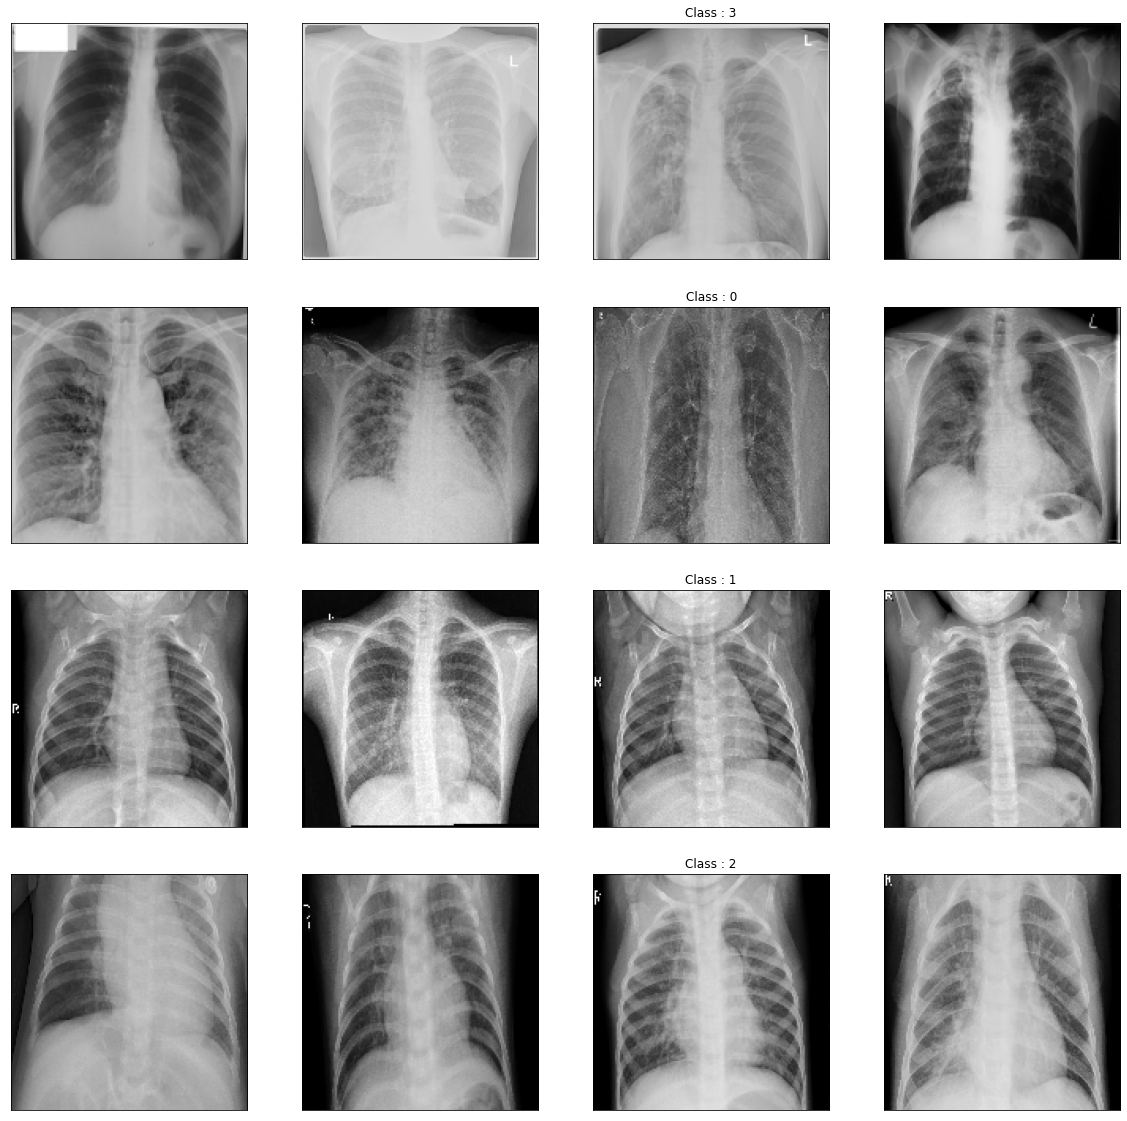

In [ ]:
_, axis_array = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
keys = list(train_dataset.data.keys()) #sample keys
for i in range(classes):
    for j in range(classes):
        tempImage = train_dataset.data[keys[i]][j]
        tempImage = np.stack((tempImage[:, :, 0],) * 3, axis=2)
        tempImage *= 255
        tempImage = np.clip(tempImage, 0, 255).astype("uint8")
        if j == 2:
            axis_array[i, j].set_title("Class : " + keys[i])
        axis_array[i, j].imshow(tempImage, cmap="gray")
        axis_array[i, j].xaxis.set_visible(False)
        axis_array[i, j].yaxis.set_visible(False)  
plt.show()


###Build The Model

---



In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Creating network
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape= (img_rows, img_cols, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
# To further prevent overfitting, add dropout
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

### Train The Model

In [ ]:

training = []
testing = []
for iteration in range(iterations):
    frac_done = iterations / iterations
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    #Intialize the base learner, vector of initial parameters
    old_theta = model.get_weights()
    # Get a sample task from the full dataset to perform SGD
    task = train_dataset.get_Task(inner_batch_size, inner_iters, train_shots, classes)
    #For each image in the task perform gradient descent
    for images, labels in task:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_theta = model.get_weights()
    # Perform SGD for the meta step.
    for theta in range(len(new_theta)):
        new_theta[theta] = old_theta[theta] + (
            (new_theta[theta] - old_theta[theta]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_theta)
    # Evaluation loop
    if iteration % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            train_set, test_images, test_labels = dataset.get_Task(eval_batch_size, eval_iters, shots, classes, split=True            )
            old_vars = model.get_weights()
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            model.set_weights(old_theta)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if iteration % 100 == 0:
            print("batch %d: train=%f test=%f" % (iteration, accuracies[0], accuracies[1]))


1/1 [==============================] - 0s 169ms/step
batch 0: train=0.250000 test=0.750000
1/1 [==============================] - 0s 68ms/step
batch 100: train=0.750000 test=0.750000
1/1 [==============================] - 0s 59ms/step
batch 200: train=0.000000 test=0.750000
1/1 [==============================] - 0s 60ms/step
batch 300: train=0.000000 test=0.500000
1/1 [==============================] - 0s 61ms/step
batch 400: train=0.500000 test=0.000000
1/1 [==============================] - 0s 59ms/step
batch 500: train=0.750000 test=0.250000
1/1 [==============================] - 0s 60ms/step
batch 600: train=0.250000 test=1.000000
1/1 [==============================] - 0s 60ms/step
batch 700: train=0.250000 test=0.250000
1/1 [==============================] - 0s 61ms/step
batch 800: train=0.250000 test=0.250000
1/1 [==============================] - 0s 61ms/step
batch 900: train=0.250000 test=0.500000
1/1 [==============================] - 0s 59ms/step


Visualize Results

1/1 [==============================] - 0s 74ms/step


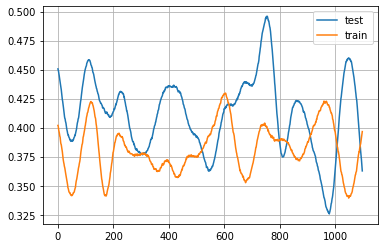

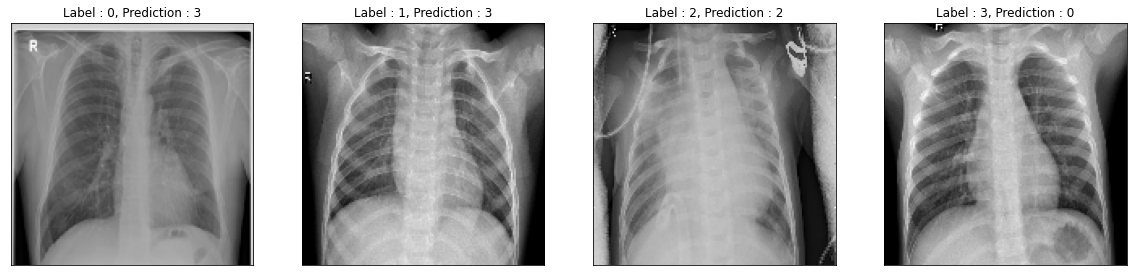

In [ ]:
# First, some preprocessing to smooth the training and testing arrays for display.
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_Task(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()


###Save The Model

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/ML/ML_Project/data/models/RespiratoryDiseaseDetection-MetaLearning-FewShot-Reptile.h5")
